In [14]:
import pandas as pd
import sys
from pathlib import Path
import pastas as ps
import seaborn as sns

# Add the 'scripts' directory to sys.path
scripts_path = Path("../scripts").resolve()
if str(scripts_path) not in sys.path:
    sys.path.append(str(scripts_path))


### Loading Input Files

In [2]:
from knmi_pull import fetch_knmi_prec_evap
data = fetch_knmi_prec_evap("249", "2000-01-01", "2025-06-01")

In [3]:
prec = data[0]
evap = data[1]

In [4]:
# 1. Load Excel file
file_path_excel = Path("../input_files/input_single/13_7_HB21_PB1.xlsx")
df_head = pd.read_excel(file_path_excel)

print(df_head.head())

             DateTime  HB28_PB1
0 2023-11-10 00:00:00       NaN
1 2023-11-10 01:00:00       NaN
2 2023-11-10 02:00:00       NaN
3 2023-11-10 03:00:00       NaN
4 2023-11-10 04:00:00       NaN


In [5]:
# 2. Convert 'time' column to datetime using flexible parsing
df_head['time'] = pd.to_datetime(df_head['DateTime'], format='mixed', dayfirst=True)

# 3. Set datetime column as index
df_head.set_index('time', inplace=True)

# 4. Resample to daily mean
head_daily_mean = df_head['HB28_PB1'].resample("D").mean().dropna()

#### Waterhoogte systeem

In [6]:
# 1. Load Excel file
file_path_waterhoogte = Path("../input_files/input_single/waterhoogte_drieban.xlsx")
df = pd.read_excel(file_path_waterhoogte)

# 2. Convert 'datetime' column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# 3. Set datetime as index
df.set_index('datetime', inplace=True)

# 4. Resample to daily mean (will have missing dates if no data on some days)
waterhoogte_daily_mean = df['waterhoogte'].resample("D").mean()

# 5. Fill missing days with a method or value, e.g., forward fill or zero (if appropriate)
waterhoogte_daily_mean = waterhoogte_daily_mean.ffill()  # or .bfill(), or .fillna(0)

# 6. Now frequency can be inferred correctly
waterhoogte_daily_mean.index.freq = "D"

### Gegevenscontrole

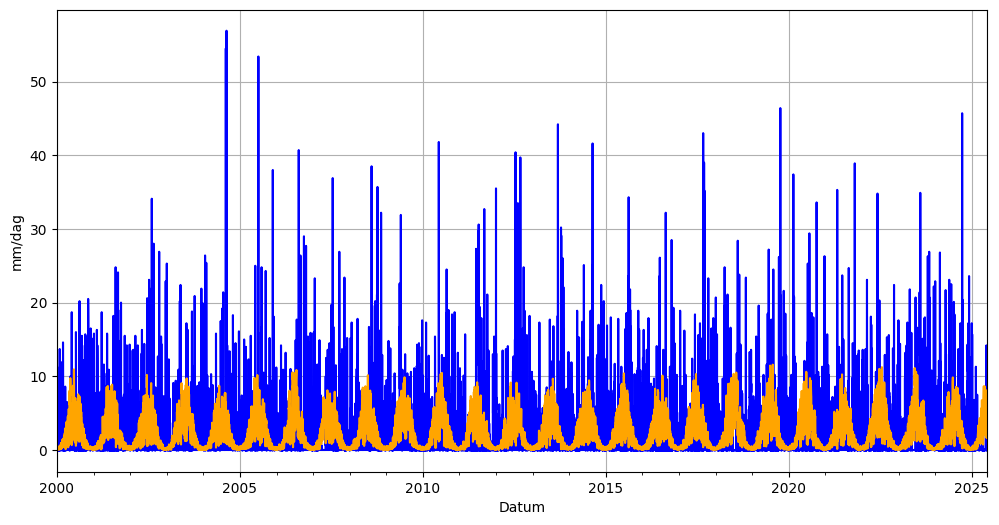

In [7]:
import matplotlib.pyplot as plt

ax1 = prec.plot(label='Precipitation', color='blue', figsize=(12, 6))
ax2 = evap.plot(label='Evaporation', color='orange')
plt.xlabel("Datum")
plt.ylabel("mm/dag")  # or your preferred unit
plt.grid(True)
plt.show()

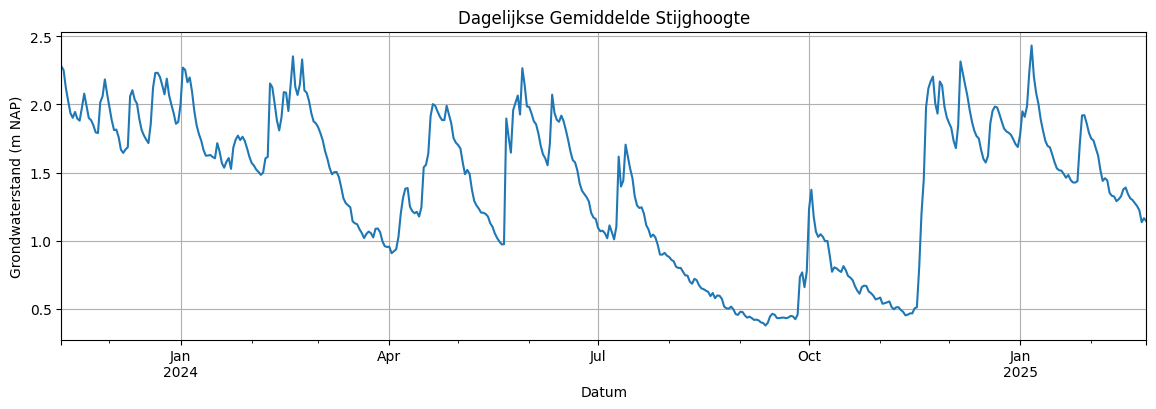

In [8]:
head_daily_mean.plot(figsize=(14, 4), title="Dagelijkse Gemiddelde Stijghoogte")
plt.xlabel("Datum")
plt.ylabel("Grondwaterstand (m NAP)")  # or your preferred unit
plt.grid(True)
plt.show()


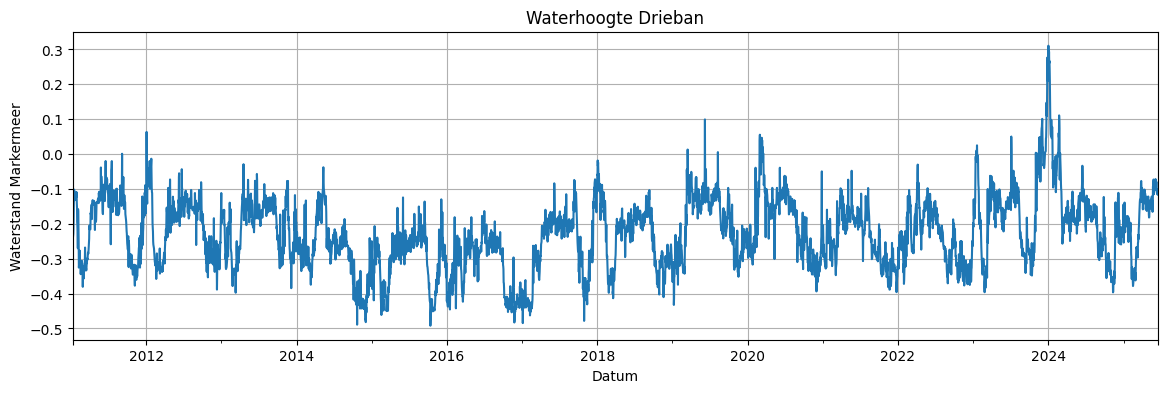

In [9]:
waterhoogte_daily_mean.plot(figsize=(14, 4), title="Waterhoogte Drieban")
plt.xlabel("Datum")
plt.ylabel("Waterstand Markermeer")  # or your preferred unit
plt.grid(True)
plt.show()


In [10]:
start_head_series = head_daily_mean.index.min()
end_head_series = head_daily_mean.index.max()

print(start_head_series, end_head_series)

2023-11-10 00:00:00 2025-02-25 00:00:00


### Monte Carlo Doen

In [11]:
# Define model components
recharge_models = {
    "Linear": ps.rch.Linear(),
    "FlexModel": ps.rch.FlexModel(),
    "Berendrecht": ps.rch.Berendrecht()
}

response_functions = {
    "Exponential": ps.Exponential(),
    "Gamma": ps.Gamma(),
    "DoubleExponential": ps.DoubleExponential(),
    "Hantush": ps.Hantush(),
    "FourParam": ps.FourParam(),
}

results = []

# Triple loop: recharge × rfunc × extra_rfunc
for rch_name, rch_model in recharge_models.items():
    for rfunc_name, rfunc in response_functions.items():
        for extra_name, extra_rfunc in response_functions.items():

            model_name = f"{rch_name}_{rfunc_name}_extra-{extra_name}"
            print(f"Running model: {model_name}")

            try:
                # 1. Create model
                ml = ps.Model(head_daily_mean, name=model_name)

                # 2. Add recharge stressmodel
                rm = ps.RechargeModel(
                    prec=prec,
                    evap=evap,
                    recharge=rch_model,
                    rfunc=rfunc,
                    name="rch"
                )
                ml.add_stressmodel(rm)

                # 3. Add 'extra' stressmodel with varying rfunc
                extra = ps.StressModel(
                    waterhoogte_daily_mean,
                    rfunc=extra_rfunc,
                    name="extra",
                    settings="prec",
                    up=True
                )
                ml.add_stressmodel(extra)

                # 4. Add noise model
                ml.add_noisemodel(ps.ArNoiseModel())

                # 5. Solve the model
                ml.solve(
                    tmin=start_head_series,
                    tmax=end_head_series,
                    solver=ps.LeastSquares(),
                    report=False
                )

                # 6. Store evaluation metrics
                stats = ml.stats
                results.append({
                    "model": model_name,
                    "RechargeModel": rch_name,
                    "RechargeRfunc": rfunc_name,
                    "ExtraRfunc": extra_name,
                    "EVP": stats.evp(),
                    "R2": stats.rsq(),
                    "RMSE": stats.rmse(),
                    "AIC": stats.aic(),
                    "BIC": stats.bic()
                })

            except Exception as e:
                print(f"Model {model_name} failed: {e}")
                results.append({
                    "model": model_name,
                    "RechargeModel": rch_name,
                    "RechargeRfunc": rfunc_name,
                    "ExtraRfunc": extra_name,
                    "EVP": None,
                    "R2": None,
                    "RMSE": None,
                    "AIC": None,
                    "BIC": None,
                    "error": str(e)
                })

# Convert results to DataFrame and sort
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="EVP", ascending=False)

Running model: Linear_Exponential_extra-Exponential
Running model: Linear_Exponential_extra-Gamma
Running model: Linear_Exponential_extra-DoubleExponential
Running model: Linear_Exponential_extra-Hantush
Running model: Linear_Exponential_extra-FourParam
Running model: Linear_Gamma_extra-Exponential
Running model: Linear_Gamma_extra-Gamma
Running model: Linear_Gamma_extra-DoubleExponential
Running model: Linear_Gamma_extra-Hantush
Running model: Linear_Gamma_extra-FourParam
Running model: Linear_DoubleExponential_extra-Exponential
Running model: Linear_DoubleExponential_extra-Gamma
Running model: Linear_DoubleExponential_extra-DoubleExponential
Running model: Linear_DoubleExponential_extra-Hantush
Running model: Linear_DoubleExponential_extra-FourParam


The integral is probably divergent, or slowly convergent.The integral is probably divergent, or slowly convergent.

Running model: Linear_Hantush_extra-Exponential


Model parameters could not be estimated well.


Running model: Linear_Hantush_extra-Gamma
Running model: Linear_Hantush_extra-DoubleExponential


Model parameters could not be estimated well.


Running model: Linear_Hantush_extra-Hantush
Running model: Linear_Hantush_extra-FourParam


invalid value encountered in castModel parameters could not be estimated well.


Running model: Linear_FourParam_extra-Exponential
Running model: Linear_FourParam_extra-Gamma
Running model: Linear_FourParam_extra-DoubleExponential
Running model: Linear_FourParam_extra-Hantush
Running model: Linear_FourParam_extra-FourParam
Running model: FlexModel_Exponential_extra-Exponential
Running model: FlexModel_Exponential_extra-Gamma
Running model: FlexModel_Exponential_extra-DoubleExponential
Running model: FlexModel_Exponential_extra-Hantush
Running model: FlexModel_Exponential_extra-FourParam
Running model: FlexModel_Gamma_extra-Exponential
Running model: FlexModel_Gamma_extra-Gamma
Running model: FlexModel_Gamma_extra-DoubleExponential
Running model: FlexModel_Gamma_extra-Hantush
Running model: FlexModel_Gamma_extra-FourParam
Running model: FlexModel_DoubleExponential_extra-Exponential
Running model: FlexModel_DoubleExponential_extra-Gamma
Running model: FlexModel_DoubleExponential_extra-DoubleExponential
Running model: FlexModel_DoubleExponential_extra-Hantush
Running 

Model parameters could not be estimated well.


Running model: FlexModel_Hantush_extra-FourParam


The integral is probably divergent, or slowly convergent.The integral is probably divergent, or slowly convergent.

Running model: FlexModel_FourParam_extra-Exponential
Running model: FlexModel_FourParam_extra-Gamma
Running model: FlexModel_FourParam_extra-DoubleExponential
Running model: FlexModel_FourParam_extra-Hantush
Running model: FlexModel_FourParam_extra-FourParam


The integral is probably divergent, or slowly convergent.The integral is probably divergent, or slowly convergent.

Running model: Berendrecht_Exponential_extra-Exponential
Running model: Berendrecht_Exponential_extra-Gamma
Running model: Berendrecht_Exponential_extra-DoubleExponential
Running model: Berendrecht_Exponential_extra-Hantush
Running model: Berendrecht_Exponential_extra-FourParam


The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.

Running model: Berendrecht_Gamma_extra-Exponential
Running model: Berendrecht_Gamma_extra-Gamma
Running model: Berendrecht_Gamma_extra-DoubleExponential
Running model: Berendrecht_Gamma_extra-Hantush
Running model: Berendrecht_Gamma_extra-FourParam
Running model: Berendrecht_DoubleExponential_extra-Exponential
Running model: Berendrecht_DoubleExponential_extra-Gamma
Running model: Berendrecht_DoubleExponential_extra-DoubleExponential
Running model: Berendrecht_DoubleExponential_extra-Hantush
Running model: Berendrecht_DoubleExponential_extra-FourParam
Running model: Berendrecht_Hantush_extra-Exponential
Running model: Berendrecht_Hantush_extra-Gamma
Running model: Berendrecht_Hantush_extra-DoubleExponential
Running model: Berendrecht_Hantush_extra-Hantush
Running model: Berendrecht_Hantush_extra-FourParam
Running model: Berendrecht_FourParam_extra-Exponential
Running model: Berendrecht_FourParam_extra-Gamma
Running model: Berendrecht_FourParam_extra-DoubleExponential
Running model: Ber

The integral is probably divergent, or slowly convergent.The integral is probably divergent, or slowly convergent.

In [12]:
results_df

,model,RechargeModel,RechargeRfunc,ExtraRfunc,EVP,R2,RMSE,AIC,BIC
14,Linear_DoubleExponential_extra-FourParam,Linear,DoubleExponential,FourParam,83.124946,0.831171,0.222969,-2195.131423,-2149.358142
4,Linear_Exponential_extra-FourParam,Linear,Exponential,FourParam,76.924954,0.768847,0.260899,-2192.665267,-2155.214401
10,Linear_DoubleExponential_extra-Exponential,Linear,DoubleExponential,Exponential,76.805131,0.767957,0.261400,-2194.795281,-2157.344415
13,Linear_DoubleExponential_extra-Hantush,Linear,DoubleExponential,Hantush,76.583187,0.765579,0.262736,-2190.778572,-2149.166499
11,Linear_DoubleExponential_extra-Gamma,Linear,DoubleExponential,Gamma,75.759493,0.757513,0.267218,-2190.992360,-2149.380287
...,...,...,...,...,...,...,...,...,...
18,Linear_Hantush_extra-Hantush,Linear,Hantush,Hantush,0.000000,-0.009349,0.545183,-2074.452681,-2037.001815
43,FlexModel_Hantush_extra-Hantush,FlexModel,Hantush,Hantush,0.000000,-0.023963,0.549115,-2069.113378,-2019.178891
68,Berendrecht_Hantush_extra-Hantush,Berendrecht,Hantush,Hantush,0.000000,-0.015943,0.546961,-2070.297514,-2024.524233
69,Berendrecht_Hantush_extra-FourParam,Berendrecht,Hantush,FourParam,0.000000,-0.068660,0.560972,-2068.643094,-2018.708606




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


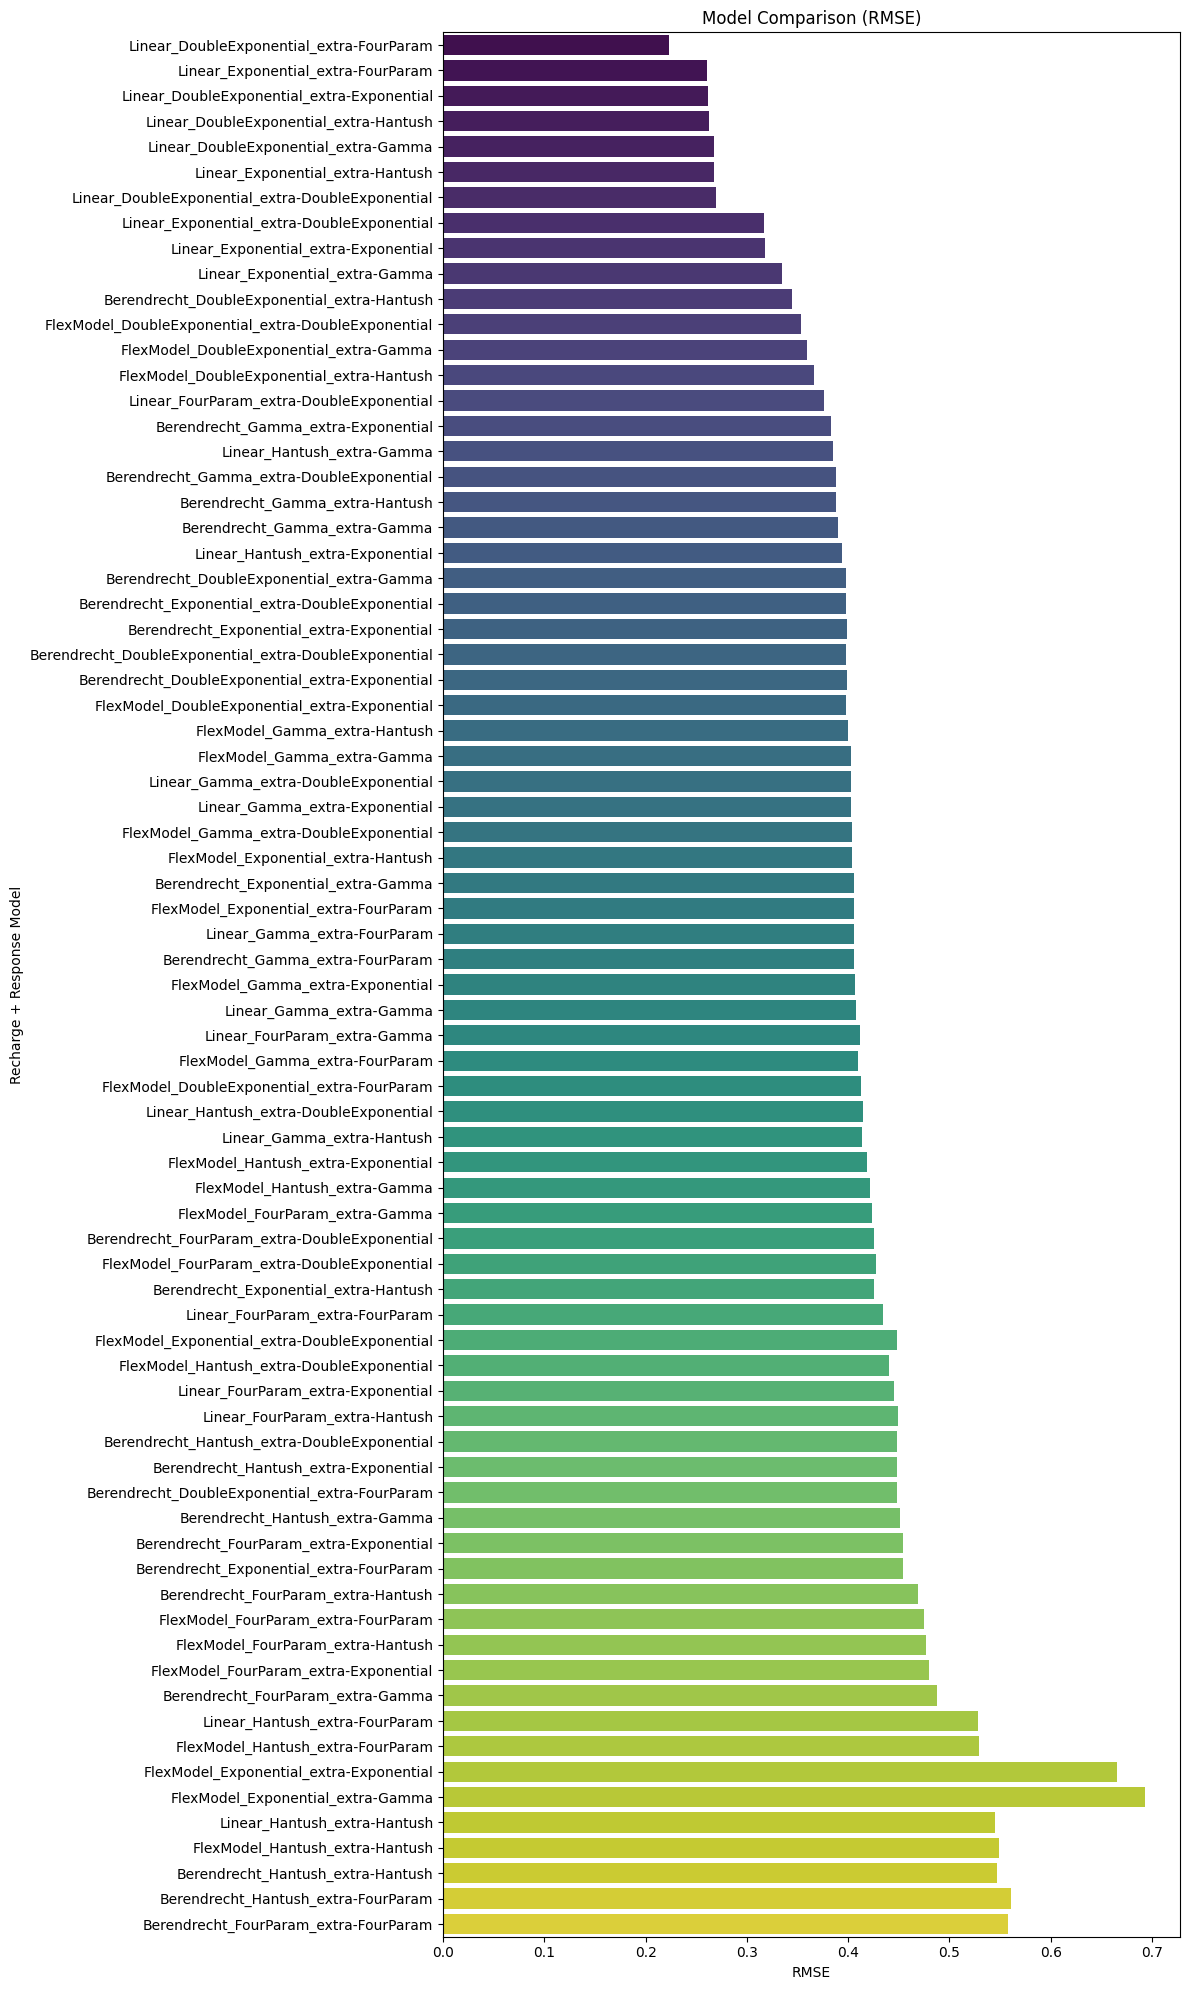

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size BEFORE plotting
plt.figure(figsize=(12, 20))  # wider and taller

# Create the plot
sns.barplot(data=results_df, y="model", x="RMSE", palette="viridis")
plt.title("Model Comparison (RMSE)")
plt.xlabel("RMSE")
plt.ylabel("Recharge + Response Model")
plt.tight_layout()
plt.show()


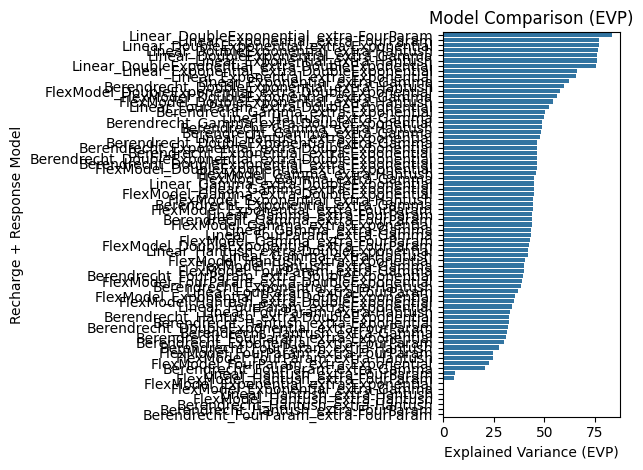

In [17]:
sns.barplot(data=results_df, y="model", x="EVP")
plt.title("Model Comparison (EVP)")
plt.xlabel("Explained Variance (EVP)")
plt.ylabel("Recharge + Response Model")
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


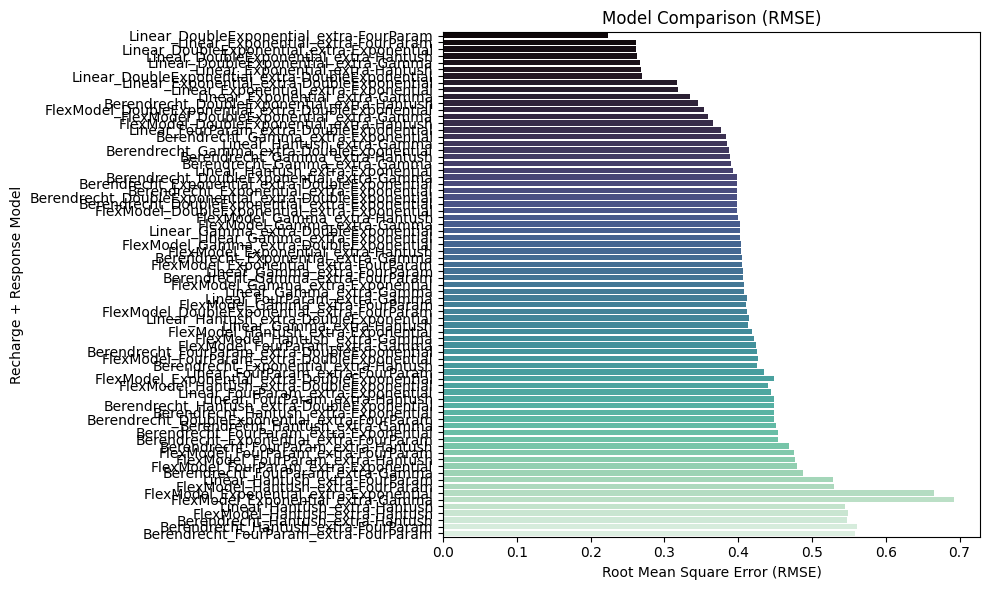

In [18]:
# Plot RMSE separately
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, y="model", x="RMSE", palette="mako")
plt.title("Model Comparison (RMSE)")
plt.xlabel("Root Mean Square Error (RMSE)")
plt.ylabel("Recharge + Response Model")
plt.tight_layout()
plt.show()